In [1]:
import numpy as np
import pandas as pd
import random

import diurnal_misinformation
from diurnal_misinformation.config import GermanyConfig
from diurnal_misinformation.enums import Clusters
from diurnal_misinformation.fourier_utils import FourierRoutine, plot_signal_and_recombined, style_extrema_stats_df, style_mwu_comparison_df, get_increased_activity_with_end, style_dip_df
from diurnal_misinformation.path_utils import save_plot, save_to_latex
from diurnal_misinformation.utils import shift_rows_by, format_h_min

In [2]:
random_seed = 12
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
config = GermanyConfig()
fourier_routine = FourierRoutine(config)

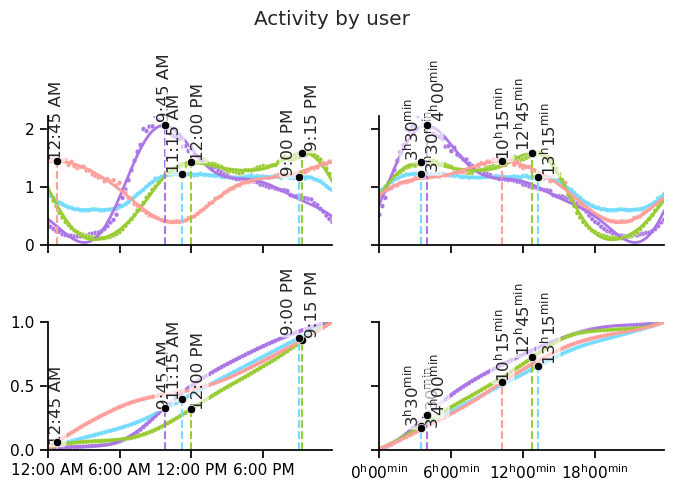

In [4]:
activity_result, ratio_result, disinf_activity_result = fourier_routine.by_user('all', save_plots=False, index_slice=Clusters.order());
activity_result.figure

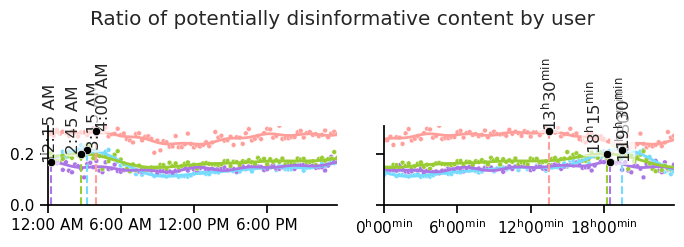

In [5]:
ratio_result.figure

## Comparison to Italy

In [6]:
from diurnal_misinformation.config import ItalyConfig
italy_config = ItalyConfig()
italy_routine = FourierRoutine(italy_config)
italy_activity = italy_routine.activity_by_user('all')

In [7]:
def get_args_for(recomp, index_slice, onset=None):
    res = (r.loc[index_slice] for r in (recomp.recomposed_signal, recomp.signal))
    if onset is not None:
        res = (shift_rows_by(r, onset) for r in res)
    return res 

def compare_results(r_main, r_background, index_slice, normalize=False, onset_main=None, onset_background=None, **shared_kwargs):
    if (onset_main is None) ^ (onset_background is None):
        raise Exception("Check alignment")
    shared_kwargs = dict(ampm="ampm" if onset_main is None else "durationvarsize", prepare=lambda df:(df / df.iloc[0].mean() if normalize else df), hatch=False, scatter_kwargs=dict(alpha=0)) | shared_kwargs
    fig, ax = plot_signal_and_recombined(*get_args_for(r_background, index_slice, onset_background), line_kwargs = dict(linestyle="dotted"), annotate=0, **shared_kwargs)
    plot_signal_and_recombined(*get_args_for(r_main, index_slice, onset_main), annotate=1, ax=ax, **shared_kwargs)
    if not normalize:
        m = max(r_main.signal.loc[index_slice].max().max(), r_background.signal.loc[index_slice].max().max())
        ax.set_ylim(0, m)
    return fig, ax

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


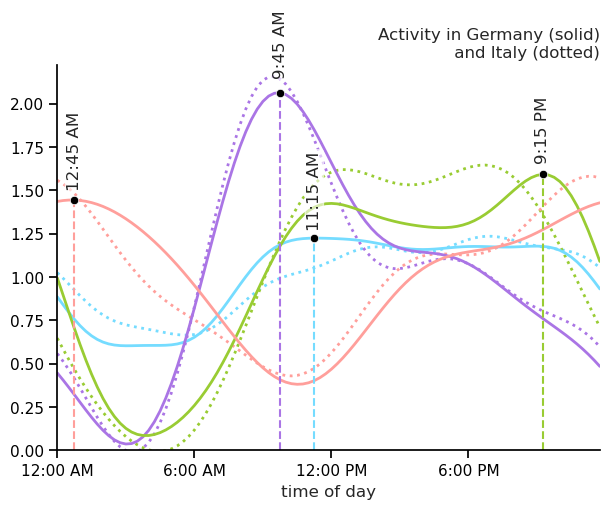

In [8]:
fig, ax = compare_results(activity_result, italy_activity, Clusters.order(), normalize=True, **fourier_routine.shared_plot_kwargs)
save_plot(fig, f'compare_activity_by_user_fourier_clocktime', config, 'all')
ax.set_title("Activity in Germany (solid)\n and Italy (dotted)", loc="right")
ax.set_xlabel("time of day");

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


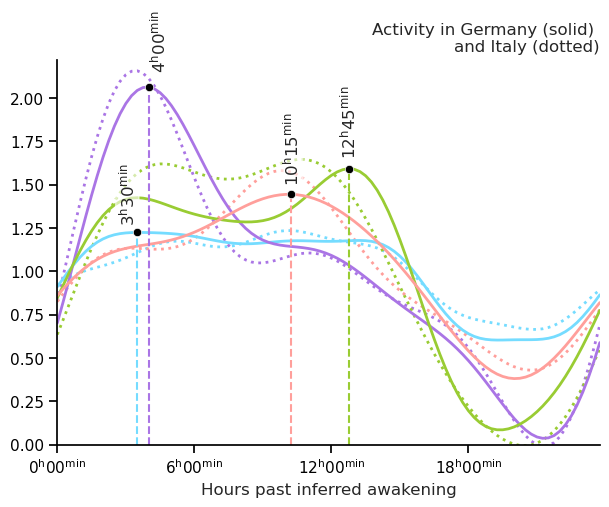

In [9]:
fig, ax = compare_results(activity_result, italy_activity, Clusters.order(), normalize=True, 
                          onset_main=activity_result.increased_activity, 
                          onset_background=italy_activity.increased_activity, **fourier_routine.shared_plot_kwargs)
save_plot(fig, f'compare_activity_by_user_fourier_waking', config, 'all')
ax.set_title("Activity in Germany (solid) \nand Italy (dotted)", loc="right")
ax.set_xlabel("Hours past inferred awakening");

In [10]:
italy_disinf_ratio = italy_routine.disinf_ratio_by_user('all')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


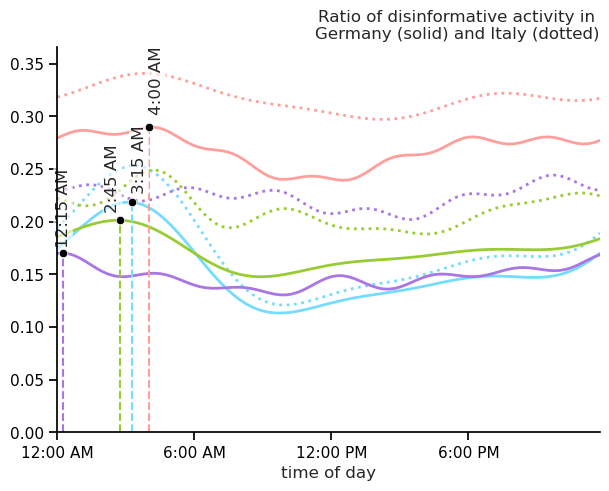

In [11]:
fig, ax = compare_results(ratio_result, italy_disinf_ratio, Clusters.order(), normalize=False, **fourier_routine.shared_plot_kwargs)
save_plot(fig, f'compare_disinf_ratio_by_user_fourier_clocktime', config, 'all')
ax.set_title("Ratio of disinformative activity in \nGermany (solid) and Italy (dotted)", loc="right")
ax.set_xlabel("time of day");

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


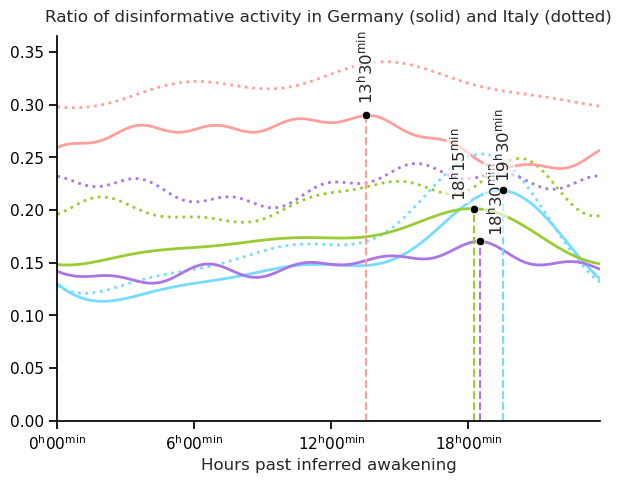

In [12]:
fig, ax = compare_results(ratio_result, italy_disinf_ratio, Clusters.order(), normalize=False, 
                          onset_main=activity_result.increased_activity, 
                          onset_background=italy_activity.increased_activity,
                          **fourier_routine.shared_plot_kwargs)
save_plot(fig, f'compare_disinf_ratio_by_user_fourier_waking', config, 'all')
ax.set_title("Ratio of disinformative activity in Germany (solid) and Italy (dotted)", pad=10)
ax.set_xlabel("Hours past inferred awakening");

## Extrema

In [13]:
statsignals = {"activity": activity_result, "potentially disinformative content ratio": ratio_result, "potentially disinformative activity": disinf_activity_result}
style_extrema_stats_df(
    activity_result.increased_activity, 
    **statsignals,
    index_slice=pd.IndexSlice[statsignals.keys(), Clusters.order(), [0,1], :]
)

## Dip test

In [14]:
dip_df_style = style_dip_df(activity_result.increased_activity, order=Clusters.order(), coarse=activity_result.signal, smooth=activity_result.recomposed_signal)
save_to_latex(config, dip_df_style, 'dip_bimodality', caption="Dip-test for unimodality of user activity curves.")
dip_df_style

## Distribution size of ratios of potentially disinformative content across clusters

In [15]:
mannwhitneyu_df_style = style_mwu_comparison_df( order=Clusters.order(), smooth=ratio_result.recomposed_signal, coarse=ratio_result.signal)
save_to_latex(config,mannwhitneyu_df_style, label='mannwhitneyu_disinf_per_cluster',
    caption="One-sided Mann-Whitney U test indicating whether the distribution of ratios of potentially disinf content throughout the day underlying the cluster named in the row is greater than the distribution underlying the cluster in the column.")
mannwhitneyu_df_style
